# Simulation to calculate polarization of the injected neutron in ABS system

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.integrate as spi
from scipy.integrate import solve_ivp
import warnings

In [2]:
%matplotlib inline
#suppress warnings
warnings.filterwarnings('ignore')

First we define function which take intput x,yand z and the magnetic field variables.<br>
This is same program as "ObtainMagneticField_ABS" but it is defined as a function so that we can call this many time during this simulation.<br>
The input parameters for this function are as follows:<br>
x, y and z co-ordinate.<br>
B1 is magnetic field by the quardapole magnetic field and related to shim by $Bs= B1\times 0.30$.<br>
B2 is magnetic field of the coil after shim.<br>
B3 is derived from B2 using formula: $B3=-B2\times (\frac{r2}{r3})^3$.<br>
B4,B5,B6 are other magnetic fields we can play with to get optimum results on polarization.<br>


In [3]:
def ABC_Coil_CalculateB(x0,y0,z0,B2,B4,B5,B6):
    z=z0
    x=x0#0.55
    y=y0#0.55
    #zrange=zmax-zmin
    #z=np.arange(zmin,zmax,zrange/2500)
    #quadrupole and shim
    z1=63.6;   dz1=0.53;    r1=0.75;                # center,roll-off,radius [cm]
    zs=z1-5.25*2.54; zt=z1-.25*2.54; dzs=3.0;       # start,end,roll-off [cm]
    B1= 7500; Bs=B1*0.30;                           # field [G]  (Bs=0: no shim)
    vg=22000;
    # small,large ring
    z2=z1+7.0                      
    r2=10;          
    #B2=35;
    z3=z2;                          
    r3=15;          
    B3=-B2*pow((r2/r3),3)
    # top,bot of MSR
    za=z2+74.4;     zb=za+40.4;
    # small,large costheta
    z4=z2+8.4;      dz4=3.2;        r4=10;          #B4=60;
    z6=z2+60;       dz6=3.2;        r6=30;          #B6=2.5;
    #more parameters
    z5=250;                         r5=1.9;         #B5=0.03;
    Bx5=z*0+B5;
    Qxy=B1/r1/2*(1-np.tanh((z-z1)/dz1)) + Bs/r1/2*(np.tanh((z-zs)/dzs)-np.tanh((z-zt)/dzs));
    dQxy=-B1/r1/2*pow((1/np.cosh((z-z1)/dz1)),2)/dz1 + Bs/r1/2*(pow((1/np.cosh((z-zs)/dzs)),2) - pow(1/np.cosh((z-zt)/dzs),2))/dzs
    Bz2=B2*pow(r2,3)/pow((pow(r2,2)+pow((z-z2),2)),(3/2));
    Bz3=B3*pow(r3,3)/pow((pow(r3,2)+pow((z-z3),2)),(3/2));
    dBz2=-3*Bz2*(z-z2)/(pow(r2,2)+pow((z-z2),2));         #dBz/dz
    dBz3=-3*Bz3*(z-z3)/(pow(r3,2)+pow((z-z3),2));         #dBz/dz
    
    Bx4=B4*pow(r4,5)/pow((pow((pow(r4,2)+pow((z-z4),2)),(3/2)) + pow((pow(r4,2)-pow(dz4,2)),(3/2))),(5/3));
    Bx6=B6*pow(r6,5)/pow((pow((pow(r6,2)+pow((z-z6),2)),(3/2)) + pow((pow(r6,2)-pow(dz6,2)),(3/2))),(5/3));
    dBx4=-5*Bx4/(pow((pow(r4,2)+pow((z-z4),2)),(3/2)) + pow((pow(r4,2)-pow(dz4,2)),(3/2)))*np.sqrt(pow(r4,2)+ pow((z-z4),2))*(z-z4);
    dBx6=-5*Bx6/(pow((pow(r6,2)+pow((z-z6),2)),(3/2)) + pow((pow(r6,2)-pow(dz6,2)),(3/2)))*np.sqrt(pow(r6,2)+ pow((z-z6),2))*(z-z6);
    Bx = Qxy*y - 1/2*(dBz2+dBz3)*x + Bx4 + Bx6 + B5;
    By = Qxy*x - 1/2*(dBz2+dBz3)*y;
    Bz = dQxy*x*y + (Bz2+Bz3) + (dBx4+dBx6)*x;
    
    B  = [Bx,By,Bz];
    Bt=np.linalg.norm(B,axis=0);
    
    return B

This is a check if the previously defined function

In [4]:
#check function
ABC_Coil_CalculateB(1,2,3,35,60,0.03,2.5)

[20000.03364722187, 9999.999695599958, 0.0044633395914626724]

The simulation program will use the magnetic field obtained from the function defined above.<br>
This simulation have input <br>
 Ballistic spin transport along the ABS, last section only of taper <br>
'z0'	 = 62.5 cm  = initial position, just before exit of ABS <br>
'r0'	 = 0.629 cm = initial aperture, radius of ABS tube <br>
'z1'	 = 250 cm   = final position, surface of injection volume <br>
'r1'	 = 5 cm     = final aperture, radius of injection volume <br>
'nev'    = 1000     = number of simulations

 ballistic motion from (\rho,\phi,0) rho<aperture, v=220m/s, |theta|<angdiv <br>
Example  >> bport(62.5,.629,250,5,1000)<br><br><br>


g=20378.9 and  v3=22000 are gyromag ratio (1/s/G) and  3He velocity (cm/s)<br>
div$=\frac{(r1+r0)}{(z1-z0)}$	is a angular divergence ("ABS dimensions": 15 mrad)


In [5]:
g=20378.9; v3=22000;
z0=62.5;
r0=0.629;
z1=250;
r1=5;
nev=100;
div=(r1+r0)/(z1-z0);

Check random number generator function

In [1]:
#check for working of random function 
A=[];
B=np.array([]);
for n in range(1, 100000):
    #random.seed(-1)
    a=random.random()
    b=n
    A.append(a)
    B.append(b)
    
#print(A,B)
plt.plot(A,B,marker='s')

NameError: name 'np' is not defined

Now define a function which will be solved as a differential equations

In [7]:
def Btm(x0,v,t):
    xt=[x0[0]+v[0]*t,x0[1]+v[1]*t,x0[2]+v[2]*t]
    B1tt=ABC_Coil_CalculateB(xt[0],xt[1],xt[2],35,60,0.03,2.5);
    return B1tt

Now loop simulated events:<br>
Number of simulated events are nev <br>
=> rho make sure the random position on entrance aperture<br>
=> for loop is used to create the event loop and information <br>
=> while loop is used to make sure the randomized creation of co-ordinate lies within dimension of our apparatus.<br>
=> B0 is the magnetic field by the ABS coil system at the begining <br>
=> B1 is the magnetic field at any point of the solution<br>

In this problem we are solving Bloch equation to obtain M:<br>
$\frac{dM(t)}{dt}=\gamma (M(t) \times B(t))$ <br>

Finally, polarization:<br>
Polarization = $\frac{M.B}{|M||B|}$

In [8]:
Pol=[];
for n in range(1, nev):
    #variables
    rho=np.sqrt(random.random())*r0; 
    phi=random.random()*2*math.pi; # random position on entrance aperture
    x0=[ rho*np.cos(phi), rho*np.sin(phi), z0 ]; 
    B0=ABC_Coil_CalculateB(x0[0],x0[1],x0[2],35,60,0.03,2.5);
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    r=99999; 
    while(r>r1):  # choose random direction within exit aperture
        ctheta=1-(1-np.cos(div))*random.random(); phi=random.random()*2*math.pi;
        v1=(v3*math.sqrt(1-pow(ctheta,2))*np.cos(phi), v3*math.sqrt(1-pow(ctheta,2))*np.sin(phi), v3*ctheta );
         
        x1=np.array(x0)
        v=np.array(v1)
        t1=(z1-z0)/v[2];
        x1=x0+(v*t1); 
        r=math.sqrt(x1[0]*x1[0] + x1[1]*x1[1]);
    B1  = ABC_Coil_CalculateB(x1[0],x1[1],x1[2],35,60,0.03,2.5);
    B1t = np.linalg.norm(B1,axis=0);
    
    #solve bloch equation using build-in function 
    sol = solve_ivp(lambda t, y: g*np.cross(y, Btm(x0,v,t)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)

[  0.77419436  -1.69600317 250.        ]

[7.82334553e-01 1.52492746e-01 2.50000000e+02]

[ -0.59424779   1.22734099 250.        ]

[  2.97676835   2.87867961 250.        ]

[  2.68318629  -3.54048308 250.        ]

[  2.63752022  -2.89181492 250.        ]

[ -0.75371749   4.8200598  250.        ]

[ -4.84210782   0.83036347 250.        ]

[  0.82739375  -3.05250969 250.        ]

[  2.71656551  -1.45238344 250.        ]

[ 2.47250240e-01 -4.83369728e+00  2.50000000e+02]

[  1.26321771   0.6725625  250.        ]

[  2.50096642  -0.68282956 250.        ]

[  1.84273162  -2.10896056 250.        ]

[ -0.64798727  -2.91275279 250.        ]

[  2.14870241  -1.69152959 250.        ]

[  2.76602409  -0.81999928 250.        ]

[  1.49339377   3.74692334 250.        ]

[  1.41572271   4.45110319 250.        ]

[ -4.43241633  -0.65710091 250.        ]

[ -1.29310673   2.3384334  250.        ]

[ -2.79985455  -1.44596377 250.        ]

[ -2.06415876  -1.29608071 250.        ]

[  3.06938545   3.3

Now, We will get the mean and error.<br>
we can also plot the distribution

In [9]:
print(np.mean(Pol))
print(np.std(Pol)/np.sqrt(nev))

0.9989362066235857
0.00011362975818840753


<function matplotlib.pyplot.show(close=None, block=None)>

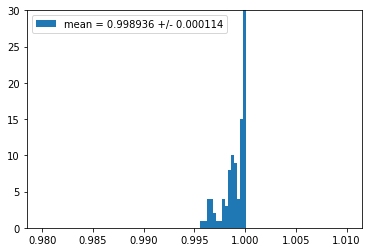

In [10]:
plt.hist(Pol,100,range=[0.98,1.01]);
plt.ylim([0, 30])
plt.legend(["mean = "+str("{:.6f}".format(np.mean(Pol)))+" +/- "+str("{:.6f}".format(np.std(Pol)/np.sqrt(nev))) ] )
plt.show

In [11]:
print("Running B2="+str(10)+", B3="+str(11)+", B5="+str(35)+", B6="+str(9)+" with "+str(4)+" events in a loop")

Running B2=10, B3=11, B5=35, B6=9 with 4 events in a loop
